In [1]:
import sys
sys.path.append("../library")

In [2]:
import math
# import columns.py for csv processing
from columns import read_csv, write_csv
from __future__ import print_function, division
from thinkbayes2 import Suite, Pmf, Mean, MeanVar, EvalPoissonPmf, \
    MakeCdfFromList, MakeNormalPmf, MakeMixture, MakePoissonPmf, MakeExponentialPmf, \
    PmfProbLess, PmfProbEqual
import thinkplot
# refer to https://github.com/AllenDowney/ThinkBayes2/blob/master/code/hockey.py

In [3]:
class Game(object):
    """
    Represents a game.
    Attributes are set in columns.read_csv.
    """
    convert = dict()

    def clean(self):
        self.goals = self.pd1 + self.pd2 + self.pd3

In [4]:
def ProcessScoresTeamwise(pairs):
    """Average number of goals for each team.
    pairs: map from (team1, team2) to [(score1, score2)], list of (score1, score2)
    """
    # map from team to list of goals scored
    goals_scored = {}
    for key, entries in pairs.items():
        t1, t2 = key
#         print('team1, team2', t1, t2)
        for entry in entries:
            g1, g2 = entry
            goals_scored.setdefault(t1, []).append(g1)
            goals_scored.setdefault(t2, []).append(g2)

    # make a list of average goals scored
    lams = []
    for key, goals in goals_scored.items():
        lam = Mean(goals)
        lams.append(lam)
#     print(lams)

    # make the distribution of average goals scored
    cdf = MakeCdfFromList(lams)
    thinkplot.Cdf(cdf)
    thinkplot.Show()

    mu, var = MeanVar(lams)
    print('mu, sig', mu, math.sqrt(var))
    return (round(mu, 2), round(math.sqrt(var), 2))

In [5]:
def ProcessScoresPairwise(pairs):
    """Average number of goals for each team against each opponent.
    pairs: map from (team1, team2) to (score1, score2)
    """
    # map from (team1, team2) to list of goals scored
    goals_scored = {}
    for key, entries in pairs.items():
        t1, t2 = key
        for entry in entries:
            g1, g2 = entry
            goals_scored.setdefault((t1, t2), []).append(g1)
            goals_scored.setdefault((t2, t1), []).append(g2)

    # make a list of average goals scored
    lams = []
    for key, goals in goals_scored.items():
        if len(goals) < 3:
            continue
        lam = Mean(goals)
        lams.append(lam)
#     print(lams)
        
    # make the distribution of average goals scored
    cdf = MakeCdfFromList(lams)
    thinkplot.Cdf(cdf)
    thinkplot.Show()

    mu, var = MeanVar(lams)
    print('mu, sig', mu, math.sqrt(var))
# print BOS and VAN's history data
    print('BOS v VAN', pairs['BOS', 'VAN'])
    return (round(mu, 2), round(math.sqrt(var), 2))

In [6]:
# data processing for raw data downloaded from https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/code/hockey_data.csv
def ReadHockeyData(filename='hockey_data.csv'):
    """
    Read game scores from the data file.
    filename: string
    """
    game_list = read_csv(filename, Game)

    # map from gameID to list of two games
    games = {}
    for game in game_list:
        if game.season != 2011:
            continue
        key = game.game
        # games.setdefault(, []) to add value, if key doesn't exists, otherwise, return value list
        games.setdefault(key, []).append(game)

    # map from (team1, team2) to [(score1, score2)], list of (score1, score2)
    pairs = {}
    for key, pair in games.items():
        t1, t2 = pair
        key = t1.team, t2.team
        entry = t1.total, t2.total
        pairs.setdefault(key, []).append(entry)
        
    mu0, var0 = ProcessScoresTeamwise(pairs)
    mu1, var1 = ProcessScoresPairwise(pairs)
    return [(mu0, var0), (mu1, var1)]

No handles with labels found to put in legend.


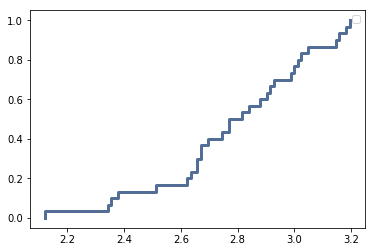

No handles with labels found to put in legend.


mu, sig 2.7878048780487803 0.2649570919209202


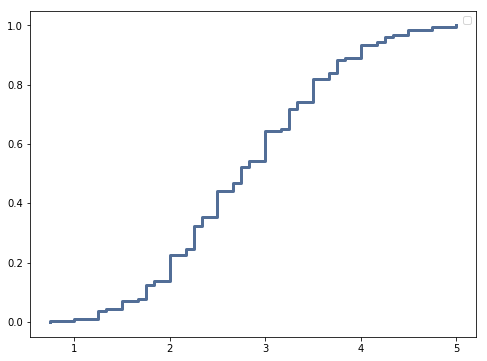

mu, sig 2.7998015873015873 0.841438732485367
BOS v VAN [(3, 1)]
[(2.79, 0.26), (2.8, 0.84)]


In [7]:
# for data analysis
data = ReadHockeyData()
print(data)

In [8]:
USE_SUMMARY_DATA = True

In [9]:
class Hockey(Suite):
    """
    Represent hypothesis about the scoring rate for team
    """
    def __init__(self, label=None):
        """
        Initialize the hockey object.
        label: str
        """
        if USE_SUMMARY_DATA:
            # prior based on each team's average goal
            mu = data[0][0]
            sigma = data[0][1]
        else:
            # prior based on each pair-wise match-up
            mu = data[1][0]
            sigma = data[1][1]
        # make pmf around center for 4 sigma
        pmf = MakeNormalPmf(mu, sigma, 4)
        super().__init__(pmf, label=label)
        
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of the data under the hypothesis.
        Evaluates the Poisson PMF for lambda and k.
        hypo: goal scoring rate in goals per game
        data: goals scored in one period
        """
        lam = hypo
#         print('lam:', lam)
        k = data
        like = EvalPoissonPmf(lam, k)
        return like

In [10]:
formats = ['pdf']

In [11]:
# prior distribution
suite1 = Hockey('bruins')
# suite1.UpdateSet([0, 2, 8, 4])
suite2 = Hockey('canucks')
# suite2.UpdateSet([1, 3, 1, 0])

thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmf(suite1)
thinkplot.Pmf(suite2)
thinkplot.Save(root='hockey0',
            xlabel='Goals per game',
            ylabel='Probability',
            formats=formats)

Writing hockey0.pdf


# Poission distribution for goal
References: 
    * [MathJax grammar](https://www.liuguogy.com/archives/markdown-mathjax-grammar.html)
    * [Poission distribution](http://www.milefoot.com/math/stat/pdfd-poisson.htm)
    * [Wiki of Poission distribution](https://en.wikipedia.org/wiki/Poisson_distribution)
    * [Mathjax wiki](https://www.mathjax.org/#demo)
1. Parameters of distribution: 
    * average goal number - $\lambda$
    * kick goal number - $k$
2. Distribution equation
    $$ P(x) = { \lambda^k e^{-\lambda} \over k!} $$

In [12]:
def MakeGoalPmf(suite, high=10):
    """
    Makes the distribution of goals scored, given distribution of lam.
    suite: distribution of goal-scoring rate
    high: upper bound
    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        # using lam (average of goal of team), high the real goal for the gam to generate pmf to update mixture distribution
        pmf = MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    # make mixture based on different goal
    mix = MakeMixture(metapmf, label=suite.label)
    return mix

# Exponential distribution for goal slot between
References: 
    * [MathJax grammar](https://www.liuguogy.com/archives/markdown-mathjax-grammar.html)
    * [Exponential distribution](http://www.milefoot.com/math/stat/pdfc-exponential.htm)
    * [Mathjax wiki](https://www.mathjax.org/#demo)
1. Parameters of distribution: 
    * average goal number - $\lambda$
    * kick goal number - $k$
2. Distribution equation
    $$ P(x) = { \lambda e^{-\lambda k} } $$

In [13]:
def MakeGoalTimePmf(suite):
    """
    Makes the distribution of time til first goal.
    suite: distribution of goal-scoring rate
    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        # time slot between goal distribution
        pmf = MakeExponentialPmf(lam, high=2, n=201)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

In [14]:
suite1.UpdateSet([0, 2, 8, 4])
suite2.UpdateSet([1, 3, 1, 0])

thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmf(suite1)
thinkplot.Pmf(suite2)
thinkplot.Save(root='hockey1',
            xlabel='Goals per game',
            ylabel='Probability',
            formats=formats)

ValueError: Normalize: total probability is zero.

In [ ]:
goal_dist1 = MakeGoalPmf(suite1)
goal_dist2 = MakeGoalPmf(suite2)

thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmf(goal_dist1)
thinkplot.Pmf(goal_dist2)
thinkplot.Save(root='hockey2',
            xlabel='Goals',
            ylabel='Probability',
            formats=formats)

In [ ]:
time_dist1 = MakeGoalTimePmf(suite1)    
time_dist2 = MakeGoalTimePmf(suite2)

print('MLE bruins', suite1.MaximumLikelihood())
print('MLE canucks', suite2.MaximumLikelihood())

thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmf(time_dist1)
thinkplot.Pmf(time_dist2)    
thinkplot.Save(root='hockey3',
               xlabel='Games until goal',
               ylabel='Probability',
               formats=formats)

In [ ]:
# goal distribution 1 and 2
diff = goal_dist1 - goal_dist2
p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)

print(p_win, p_loss, p_tie)

In [ ]:
p_overtime = PmfProbLess(time_dist1, time_dist2)
p_adjust = PmfProbEqual(time_dist1, time_dist2)
# why here need to divide by /2 ?
p_overtime += p_adjust / 2
print('p_overtime', p_overtime) 

print(p_overtime * p_tie)
p_win += p_overtime * p_tie
print('p_win', p_win)

# win the next two
p_series = p_win**2

# split the next two, win the third
p_series += 2 * p_win * (1-p_win) * p_win

print('p_series', p_series)